In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import os
from PIL import Image
import math  # 添加 math 模块导入

# 获取所有图像路径，递归查找
data = glob(r'D:\PycharmProjects\保存的参数\fingerprints\DB*\**\*.tif', recursive=True)
images = []

def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")  # 打印图像路径
        try:
            img = Image.open(img_path)
            img = img.convert("RGB")  # 确保图像为 RGB 格式
            img = img.resize((224, 224))  # 调整图像尺寸
            images.append(np.array(img))  # 转换为 numpy 数组并添加到列表中
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")
    
    return images

# 读取图像
images = readImages(data)

# 检查是否成功读取任何图像
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 将图像数据转换为 float32 类型，并归一化到 [0, 1] 之间
images_arr = np.asarray(images).astype('float32') / 255.0

# 检查图像形状
print("图像形状:", images_arr.shape)

# 将图像的通道数从 (N, 224, 224, 3) 转换为 (N, 3, 224, 224) (PyTorch 使用通道优先格式)
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(images_arr, images_arr, test_size=0.2, random_state=13)

# 将数据转换为 PyTorch 张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)

train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建 PyTorch 数据加载器
train_dataset = TensorDataset(train_X, train_ground)
valid_dataset = TensorDataset(valid_X, valid_ground)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

尝试读取图像: C:\fingerprints\DB1_B\101_1.tif
尝试读取图像: C:\fingerprints\DB1_B\101_2.tif
尝试读取图像: C:\fingerprints\DB1_B\101_3.tif
尝试读取图像: C:\fingerprints\DB1_B\101_4.tif
尝试读取图像: C:\fingerprints\DB1_B\101_5.tif
尝试读取图像: C:\fingerprints\DB1_B\101_6.tif
尝试读取图像: C:\fingerprints\DB1_B\101_7.tif
尝试读取图像: C:\fingerprints\DB1_B\101_8.tif
尝试读取图像: C:\fingerprints\DB1_B\102_1.tif
尝试读取图像: C:\fingerprints\DB1_B\102_2.tif
尝试读取图像: C:\fingerprints\DB1_B\102_3.tif
尝试读取图像: C:\fingerprints\DB1_B\102_4.tif
尝试读取图像: C:\fingerprints\DB1_B\102_5.tif
尝试读取图像: C:\fingerprints\DB1_B\102_6.tif
尝试读取图像: C:\fingerprints\DB1_B\102_7.tif
尝试读取图像: C:\fingerprints\DB1_B\102_8.tif
尝试读取图像: C:\fingerprints\DB1_B\103_1.tif
尝试读取图像: C:\fingerprints\DB1_B\103_2.tif
尝试读取图像: C:\fingerprints\DB1_B\103_3.tif
尝试读取图像: C:\fingerprints\DB1_B\103_4.tif
尝试读取图像: C:\fingerprints\DB1_B\103_5.tif
尝试读取图像: C:\fingerprints\DB1_B\103_6.tif
尝试读取图像: C:\fingerprints\DB1_B\103_7.tif
尝试读取图像: C:\fingerprints\DB1_B\103_8.tif
尝试读取图像: C:\fingerprints\DB1_B\104_1.tif


In [2]:

# 定义 GELU 激活函数
class GELUB(nn.Module):
    def __init__(self):
        super(GELUB, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 初始化 sigma

    def forward(self, input):
        return input * (1 + torch.erf(input / (math.sqrt(2) * self.sigma))) / 2

# 定义自动编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            GELUB(),  # 使用自定义的 GELUB 激活函数
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            GELUB(),  # 替换为 GELUB
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            GELUB()   # 替换为 GELUB
        )
        
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            GELUB(),  # 替换为 GELUB
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            GELUB(),  # 替换为 GELUB
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # 输出仍为 Sigmoid
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 实例化模型
autoencoder = Autoencoder()

# 使用 GPU（如果可用）
device = torch.device("cpu")
autoencoder.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)  # 使用 Adam 优化器

In [3]:

# 训练模型的函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 计算训练集损失
        train_loss.append(running_loss / len(train_loader))
        
        # 计算验证集损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        valid_loss.append(val_loss / len(valid_loader))
        
        # 打印当前 epoch 的 sigma 值
        for name, layer in model.named_modules():
            if isinstance(layer, GELUB):
                print(f"Epoch {epoch+1}: {name} sigma = {layer.sigma.item():.4f}")
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")
    
    return train_loss, valid_loss

# 训练模型
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1: encoder.1 sigma = 1.0004
Epoch 1: encoder.4 sigma = 0.9994
Epoch 1: encoder.7 sigma = 0.9980
Epoch 1: decoder.1 sigma = 0.9982
Epoch 1: decoder.4 sigma = 1.0018
Epoch 1/300, Training Loss: 0.0691, Validation Loss: 0.0716
Epoch 2: encoder.1 sigma = 0.9988
Epoch 2: encoder.4 sigma = 1.0007
Epoch 2: encoder.7 sigma = 0.9964
Epoch 2: decoder.1 sigma = 0.9967
Epoch 2: decoder.4 sigma = 1.0006
Epoch 2/300, Training Loss: 0.0588, Validation Loss: 0.0571
Epoch 3: encoder.1 sigma = 0.9996
Epoch 3: encoder.4 sigma = 1.0024
Epoch 3: encoder.7 sigma = 0.9970
Epoch 3: decoder.1 sigma = 0.9972
Epoch 3: decoder.4 sigma = 1.0015
Epoch 3/300, Training Loss: 0.0536, Validation Loss: 0.0516
Epoch 4: encoder.1 sigma = 0.9996
Epoch 4: encoder.4 sigma = 1.0040
Epoch 4: encoder.7 sigma = 0.9959
Epoch 4: decoder.1 sigma = 0.9965
Epoch 4: decoder.4 sigma = 1.0010
Epoch 4/300, Training Loss: 0.0474, Validation Loss: 0.0471
Epoch 5: encoder.1 sigma = 0.9987
Epoch 5: encoder.4 sigma = 1.0048
Epoch 5: enc

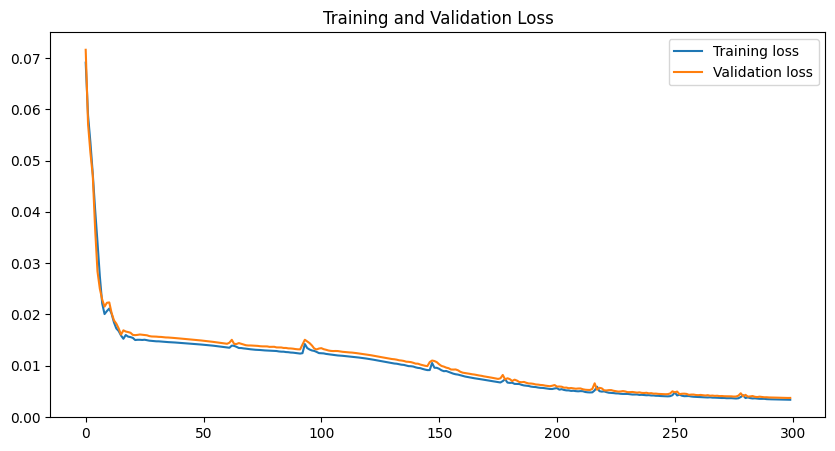

In [4]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

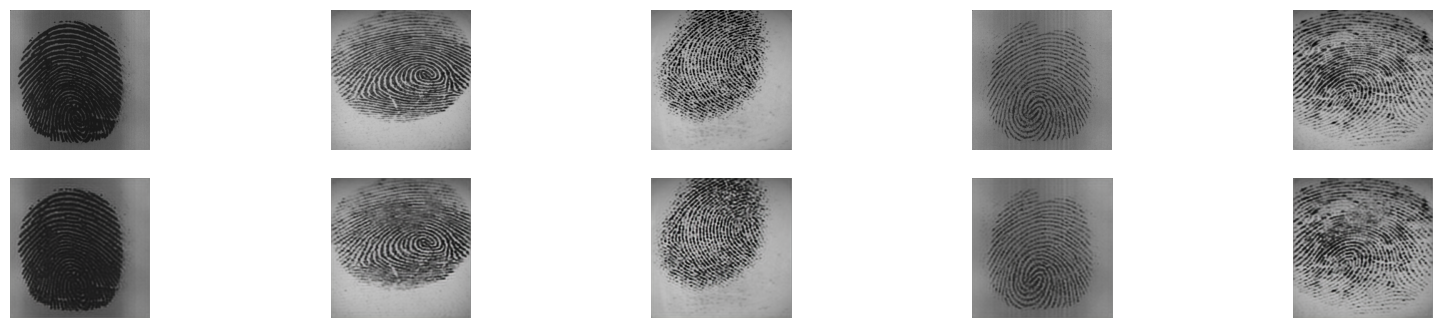

In [5]:

# 可视化重建结果
def visualize_reconstructions(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            inputs = inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()
            
            # 可视化前 5 个测试图像及其重建图像
            plt.figure(figsize=(20, 4))
            for i in range(5):
                # 原始图像
                plt.subplot(2, 5, i+1)
                plt.imshow(np.transpose(inputs[i], (1, 2, 0)))
                plt.axis('off')
                
                # 重建图像
                plt.subplot(2, 5, i+6)
                plt.imshow(np.transpose(outputs[i], (1, 2, 0)))
                plt.axis('off')
            break
    plt.show()

# 测试并可视化重建结果
visualize_reconstructions(autoencoder, valid_loader)
